In [1]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=1,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=3)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40765 instead
  warnings.warn(


In [2]:
print(client)

<Client: 'tcp://10.0.128.140:40637' processes=0 threads=0, memory=0 B>


In [3]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [4]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [5]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker


In [6]:
### Set file names

runningLocation = 'gdata'
if  runningLocation== 'local':
    hisOSSEFilePath='../data/raw/OSSE_SSHSST/'
    hisTruthFilePath='../data/raw/truth/final/'
    obsFinalFilePath='../data/raw/OSSE_SSHSST/' #the 'final' obs files: Verification obs, + NLmodel values from modTruth.
    modOSSEFilePath='../data/raw/OSSE_SSHSST/'
    # hisPertFilePath='../data/raw/perturbed/'
elif runningLocation == 'gdata':
    hisOSSEFilePath='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
    hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings
    obsFinalFilePath='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
    modOSSEFilePath='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
#     hisPertFilePath='/g/data/fu5/deg581/EAC_2yr_perturbedRun_final/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixTruth='outer_his_'
prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [7]:
### define local functions
def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")  

In [8]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    gridOut = Grid(gridIn, 
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}},
    periodic=False)
    return gridOut

def horizontalSectionROMS(grid, inData, Var, depth):
    var_data = inData[Var]
    depth_data=inData['z_rho']
    outData = grid.transform(var_data, 'Z', depth, 
        target_data=depth_data, 
        method='linear')
    return outData

In [9]:
### Open truth file
OverlappedTruthFiles = 'yes'
if OverlappedTruthFiles == 'yes':
    truth = loadOverlappedNetcdf(hisTruthFilePath,prefixTruth,filestring='08*.nc',overlapDays=7)
elif OverlappedTruthFiles == 'no':
    import glob
    chunks = {'ocean_time':1}

    filelist = glob.glob(hisTruthFilePath+prefixTruth+'08*.nc')
    #datelist = np.array(range(timeRange[0],timeRange[1],4))

    for files in filelist: 
        print(files)
        # filelist.append(files)
    truth = xr.open_mfdataset(filelist,chunks, data_vars='minimal',compat='override',coords='minimal',parallel=True, join='right') 
    # truth = dropDuplicateTimes(truth)

loaded from /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08001.nc to /g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/outer_his_08765.nc


In [10]:
truth = processROMSGrid(truth)
gridXGM = makeROMSGridObject(grid)

In [11]:
# u_eastward_top = truth.u_eastward.isel(s_rho=-1)
# v_northward_top = truth.v_northward.isel(s_rho=-1)
# v_northward = truth.v_northward

# u_bar = u_eastward_top.mean("ocean_time")
# v_bar = v_northward_top.mean("ocean_time")

# mke = (u_bar**2 + v_bar**2)

# u_prime = u_eastward_top - u_bar
# v_prime = v_northward_top - v_bar

# eke = u_prime**2 + v_prime**2

# ekemedian = eke.median("ocean_time")

# eketimemedian = eke.median("xi_rho").median("eta_rho")

# # make time series of vol/heat transport
# transectEta = 270

# v_masked = v_northward.where(v_northward<=-0.05).where(v_northward.z_rho>-2000).where(v_northward.lon_rho<155)
# v_trans = (v_masked.isel(eta_rho=transectEta)*truth.dz.isel(eta_rho=transectEta)*truth.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')


In [12]:
# truth.load()

/local/m68/deg581/tmp/ipykernel_2043908/325100791.py:117: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  axins.outline_patch.set_visible(False)


<Figure size 432x288 with 0 Axes>

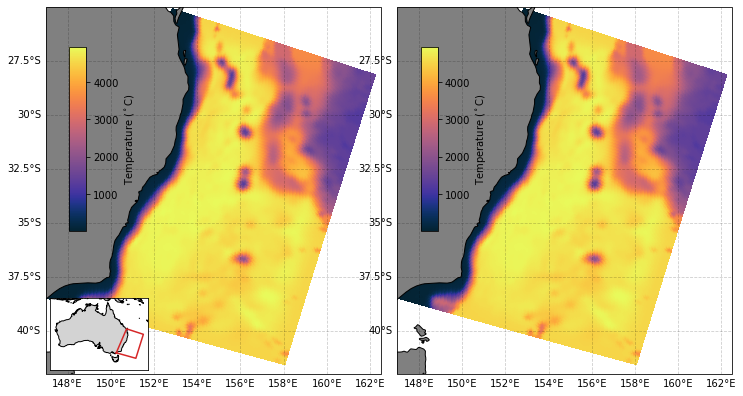

In [36]:
snap = truth

toPlotData=snap.h
# uvel = snap.u_eastward.isel(s_rho=-1).mean(dim="ocean_time").squeeze()
# vvel = snap.v_northward.isel(s_rho=-1).mean(dim="ocean_time").squeeze()
# umag = np.sqrt(uvel**2+vvel**2).values

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])
ax = None

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.thermal","vmin":15, "vmax":30, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.thermal')       
# sp = ax.streamplot(snap.lon_rho.values, snap.lat_rho.values, uvel.values, vvel.values,
#                     color=umag,
#                    linewidth=1,
#                    arrowsize = 1,
#                    density=4,
#                     cmap='pink',
#                 #    color='k',
#                    transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Temperature ($^\circ$C)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.thermal","vmin":15, "vmax":30, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
ax = plt.gca()
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.thermal')       
# sp = ax.streamplot(snap.lon_rho.values, snap.lat_rho.values, uvel.values, vvel.values,
#                     color=umag,
#                    linewidth=1,
#                    arrowsize = 1,
#                    density=4,
#                     cmap='pink',
#                 #    color='k',
#                    transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Temperature ($^\circ$C)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")

# add annotations
# title - snapshot
# Brisbane
# Sydney
# Coffs
# Newcastle
# EAC Jet
# CW eddy
# CCW eddy




axins = fig.add_axes([.11, 0.19, 0.15, 0.125], projection=ccrs.PlateCarree())
axins.set_extent([110, 165, -45, -8])
feature = axins.add_feature(Coast, edgecolor='black',facecolor='lightgray')
etas = np.array([0,316])
xis = np.array([0,271])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='C3')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(True)
axins.spines['top'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.spines['left'].set_visible(True)

In [28]:
truth

<xarray.Dataset>
Dimensions:        (tracer: 2, boundary: 4, s_rho: 30, s_w: 31, eta_rho: 317, xi_rho: 272, xi_u: 271, eta_v: 316, ocean_time: 4608)
Coordinates: (12/13)
  * s_rho          (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
  * s_w            (s_w) float64 -1.0 -0.9433 -0.8883 ... -0.02161 -0.01 0.0
    lon_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lat_rho        (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
    lon_u          (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    lat_u          (eta_rho, xi_u) float64 dask.array<chunksize=(317, 271), meta=np.ndarray>
    ...             ...
    lat_v          (eta_v, xi_rho) float64 dask.array<chunksize=(316, 272), meta=np.ndarray>
    lon_psi        (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
    lat_psi        (eta_v, xi_u) float64 dask.array<chunksize=(316, 271), meta=np.ndarray>
  * ocean_time     (ocean_time) datetime64[ns] 2011-11-28 ... 2014-01-03T20:0...
    z_w            (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 31, 317, 272), meta=np.ndarray>
    z_rho          (ocean_time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 30, 317, 272), meta=np.ndarray>
Dimensions without coordinates: tracer, boundary, eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/113)
    ntimes         int32 ...
    ndtfast        int32 ...
    dt             float64 ...
    dtfast         float64 ...
    dstart         datetime64[ns] ...
    nHIS           int32 ...
    ...             ...
    dz_w           (ocean_time, s_w, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 1, 317, 272), meta=np.ndarray>
    dz_u           (ocean_time, s_rho, eta_rho, xi_u) float64 dask.array<chunksize=(1, 30, 317, 271), meta=np.ndarray>
    dz_w_u         (ocean_time, s_w, eta_rho, xi_u) float64 dask.array<chunksize=(1, 1, 317, 271), meta=np.ndarray>
    dz_v           (ocean_time, s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(1, 30, 316, 272), meta=np.ndarray>
    dz_w_v         (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 1, 316, 272), meta=np.ndarray>
    dA             (eta_rho, xi_rho) float64 dask.array<chunksize=(317, 272), meta=np.ndarray>
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

KeyboardInterrupt: 

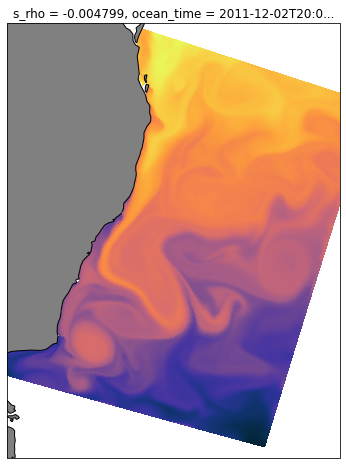

In [14]:
snap = truth

toPlotData=snap.temp.isel(s_rho=-1).isel(ocean_time=29)
uvel = snap.u_eastward.isel(ocean_time=29,s_rho=-1).squeeze()
vvel = snap.v_northward.isel(ocean_time=29,s_rho=-1).squeeze()
umag = np.sqrt(uvel**2+vvel**2).values

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.thermal","vmin":15, "vmax":30, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
ax = plt.gca()
ax.set_extent([148, 161, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, cmap='cmo.thermal')       
sp = ax.streamplot(snap.lon_rho.values, snap.lat_rho.values, uvel.values, vvel.values,
                    color=umag,
                   linewidth=1,
                   arrowsize = 1,
                   density=4,
                    cmap='pink',
                #    color='k',
                   transform=ccrs.PlateCarree())
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.6, 1, .7),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
cbar = fig.colorbar(im, cax=cax) 
cbar.set_label('Temperature ($^\circ$C)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")

# add annotations
ax.text(153,-27.5,'Brisbane  ',ha='right',va='center'), ax.plot(153,-27.5,marker='x',color='k')
ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(153.1,-30.3,'Coffs  \nHarbour  ',ha='right',va='center'), ax.plot(153.1,-30.3,marker='x',color='k')
ax.text(151.7,-32.9,'Newcastle  ',ha='right',va='center'), ax.plot(151.7,-32.9,marker='x',color='k')
arr_props=dict(arrowstyle="->",connectionstyle="arc3")
box_style=dict(boxstyle="round", fc="w")
ax.annotate("EAC jet",xy=(154,-28),xycoords='data',xytext=(156,-27.5),textcoords='data',arrowprops=arr_props,bbox=box_style)
ax.annotate("Cyclonic eddy",xy=(152.5,-36.5),xycoords='data',xytext=(153.5,-39),textcoords='data',arrowprops=arr_props,bbox=box_style)
ax.annotate("Anticyclonic eddy",xy=(155.85,-32),xycoords='data',xytext=(155,-30),textcoords='data',arrowprops=arr_props,bbox=box_style)
ax.annotate("EAC separation",xy=(152,-34.8),xycoords='data',xytext=(155,-34.5),textcoords='data',arrowprops=arr_props,bbox=box_style)




/local/m68/deg581/tmp/ipykernel_2043908/2216471999.py:141: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  axins.outline_patch.set_visible(False)


<Figure size 432x288 with 0 Axes>

<Figure size 885.6x576 with 0 Axes>

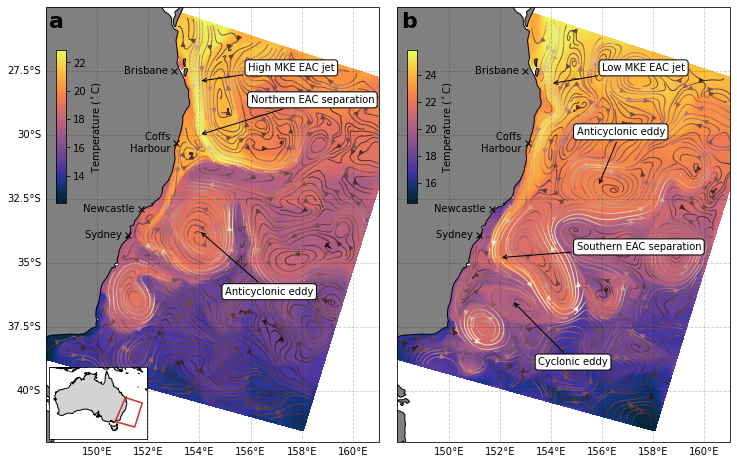

In [39]:

def addSubplot_spatialMap_streamplot_colorbar(grd,input,u,v,gs,nrow,ncol, labelText=None, pcol_kwargs={}, str_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)
    st = ax.streamplot(grd.lon_rho.values, grd.lat_rho.values, u.values, v.values,**str_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.55, 1, .7),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,cbar

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])
ax = None

def addSubplot_spatialMap_streamplot_colorbar_labels(grd,input,u,v,gs,nrow,ncol, labelText=None, pcol_kwargs={}, str_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im = ax.pcolormesh(input.lon_rho,input.lat_rho,input,**pcol_kwargs)
    st = ax.streamplot(grd.lon_rho.values, grd.lat_rho.values, u.values, v.values,**str_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = True
    cax = inset_axes(ax,
                width="3%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.03,.55, 1, .7),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
    cbar = fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
    ax.set_title('')
    return ax,cbar

gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.05, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[12.3,8])
ax = None



snap1 = truth.isel(ocean_time=29)
snap1["umag"] = np.sqrt(snap1.u_eastward.isel(s_rho=-1).squeeze()**2+snap1.v_northward.isel(s_rho=-1).squeeze()**2)

str_kwargs = {"color":snap1.umag.values,
              "linewidth":1,
              "arrowsize":1,
              "density":4,
              "cmap":"pink",
             "transform":ccrs.PlateCarree()}

pcol_kwargs = {"cmap":"cmo.thermal"}


ax,cbar = addSubplot_spatialMap_streamplot_colorbar_labels(snap1,snap1.temp.isel(s_rho=-1),snap1.u_eastward.isel(s_rho=-1).squeeze(),snap1.v_northward.isel(s_rho=-1).squeeze()  ,gs,0,1,'b',pcol_kwargs,str_kwargs)


cbar.set_label('Temperature ($^\circ$C)')
ax.set_title('')  
ax.set(ylabel="Latitude", xlabel="Longitude")

# add annotations
ax.text(153,-27.5,'Brisbane  ',ha='right',va='center'), ax.plot(153,-27.5,marker='x',color='k')
ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(153.1,-30.3,'Coffs  \nHarbour  ',ha='right',va='center'), ax.plot(153.1,-30.3,marker='x',color='k')
ax.text(151.7,-32.9,'Newcastle  ',ha='right',va='center'), ax.plot(151.7,-32.9,marker='x',color='k')
arr_props=dict(arrowstyle="->",connectionstyle="arc3")
box_style=dict(boxstyle="round", fc="w")
ax.annotate("Low MKE EAC jet",xy=(154,-28),xycoords='data',xytext=(156,-27.5),textcoords='data',arrowprops=arr_props,bbox=box_style)
ax.annotate("Cyclonic eddy",xy=(152.5,-36.5),xycoords='data',xytext=(153.5,-39),textcoords='data',arrowprops=arr_props,bbox=box_style)
ax.annotate("Anticyclonic eddy",xy=(155.85,-32),xycoords='data',xytext=(155,-30),textcoords='data',arrowprops=arr_props,bbox=box_style)
ax.annotate("Southern EAC separation",xy=(152,-34.8),xycoords='data',xytext=(155,-34.5),textcoords='data',arrowprops=arr_props,bbox=box_style)



snap2 = truth.sel(ocean_time='2012-08-28T00:00')
snap2["umag"] = np.sqrt(snap2.u_eastward.isel(s_rho=-1).squeeze()**2+snap2.v_northward.isel(s_rho=-1).squeeze()**2)

str_kwargs = {"color":snap2.umag.values,
              "linewidth":1,
              "arrowsize":1,
              "density":4,
              "cmap":"pink",
             "transform":ccrs.PlateCarree()}
ax,cbar = addSubplot_spatialMap_streamplot_colorbar(snap2,snap2.temp.isel(s_rho=-1),snap2.u_eastward.isel(s_rho=-1).squeeze(),snap2.v_northward.isel(s_rho=-1).squeeze()  ,gs,0,0,'a',pcol_kwargs,str_kwargs)
cbar.set_label('Temperature ($^\circ$C)')

ax.text(153,-27.5,'Brisbane  ',ha='right',va='center'), ax.plot(153,-27.5,marker='x',color='k')
ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')
ax.text(153.1,-30.3,'Coffs  \nHarbour  ',ha='right',va='center'), ax.plot(153.1,-30.3,marker='x',color='k')
ax.text(151.7,-32.9,'Newcastle  ',ha='right',va='center'), ax.plot(151.7,-32.9,marker='x',color='k')
arr_props=dict(arrowstyle="->",connectionstyle="arc3")
box_style=dict(boxstyle="round", fc="w")
ax.annotate("High MKE EAC jet",xy=(154,-27.9),xycoords='data',xytext=(155.9,-27.5),textcoords='data',arrowprops=arr_props,bbox=box_style)
# ax.annotate("Cyclonic eddy",xy=(152.5,-36.5),xycoords='data',xytext=(153.5,-39),textcoords='data',arrowprops=arr_props,bbox=box_style)
ax.annotate("Anticyclonic eddy",xy=(154,-33.75),xycoords='data',xytext=(155,-36.25),textcoords='data',arrowprops=arr_props,bbox=box_style)
ax.annotate("Northern EAC separation",xy=(154,-30),xycoords='data',xytext=(156,-28.75),textcoords='data',arrowprops=arr_props,bbox=box_style)





axins = fig.add_axes([.11, 0.13, 0.15, 0.125], projection=ccrs.PlateCarree())
axins.set_extent([110, 165, -45, -8])
feature = axins.add_feature(Coast, edgecolor='black',facecolor='lightgray')
etas = np.array([0,316])
xis = np.array([0,271])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='C3')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(True)
axins.spines['top'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.spines['left'].set_visible(True)

In [ ]:
truth.ocean_time.sel(ocean_time='2012-08-28T00:00')

In [14]:
STOP

NameError: name 'STOP' is not defined

In [ ]:
longRun = xr.open_dataset('/g/data/fu5/deg581/ana/22yr_notide/22yr_barra_nt_outer_avg_*_v_northward_5daymn.nc')

longRun_zeta= xr.open_dataset('/g/data/fu5/deg581/ana/22yr_notide/22yr_barra_nt_outer_avg_*_zeta_5daymn.nc')

longRun_zeta = longRun_zeta.mean(dim='ocean_time')

longRun_Zo_rho = (truth.hc * truth.s_rho + truth.Cs_r * truth.h) / (truth.hc + truth.h)
longRun_z_rho = longRun_zeta.zeta + (longRun_zeta.zeta+truth.h)*longRun_Zo_rho

longRun_Zo_w = (truth.hc * truth.s_w + truth.Cs_w * truth.h) / (truth.hc + truth.h)
longRun_z_w = longRun_Zo_w * (longRun_zeta.zeta+truth.h) + longRun_zeta.zeta

longRun_dz = longRun_z_w.diff(dim='s_w')

In [ ]:
longRun_dzExtract = longRun_dz.isel(eta_rho=transectEta,drop=True)
longRun_dzExtract = longRun_dzExtract.rename({'s_w': 's_rho'})

In [ ]:
longRunExtract = longRun.v_northward[:,:,transectEta,:] #this is right
longRun_z_rhoExtract = longRun_z_rho.isel(eta_rho=transectEta)
longRunMasked = longRunExtract.where(longRunExtract<=-0.05).where(longRun_z_rhoExtract>-2000).where(longRunExtract.lon_rho<155)

In [ ]:
longRunTrans = (longRunMasked*longRun_dzExtract.assign_coords({"s_rho": longRunMasked.s_rho})*truth.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')

In [ ]:
VtransMedian = np.nanmedian(longRunTrans.values)
VtransStd = np.nanstd(longRunTrans.values)
EKEMedian = 0.0698
EKEStd = 0.0208

In [ ]:
print(VtransMedian)
print(VtransStd)

In [ ]:
fig,ax=plt.subplots()
xx=truth.lon_rho.where(truth.lon_rho<155).isel(eta_rho=transectEta)
yy=truth.lat_rho.where(truth.lon_rho<155).isel(eta_rho=transectEta)
ax.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)


# truth.lon_rho.where(truth.lon_rho<155).isel(eta_rho=transectEta,drop=True).values

In [ ]:
mke.load()
ekemedian.load()

In [ ]:
# combine all figures together
plt.rcParams.update({'font.size': 22})


gs = gridspec.GridSpec(nrows=2,ncols=4, width_ratios=[1,1,0.5,0.5])
plt.cla()
plt.clf()
fig = plt.figure(figsize=[30,11.25])
ax = None


ax1 = fig.add_subplot(gs[:,0], projection=ccrs.PlateCarree())
ax1.set_extent([148, 161, -42, -25])
im = mke.plot(ax=ax1,x='lon_rho',y='lat_rho',cmap=cmocean.cm.amp, add_colorbar=False)
hh = grid.h.plot.contour(ax=ax1,x='lon_rho',y='lat_rho',levels=[500,1500,2500,3500,4500],colors='black',linewidths=0.5)
plt.clabel(hh, inline=True, fontsize=8)
feature = ax1.add_feature(Coast, edgecolor='black',facecolor='gray')
ax1.set_xlabel('Longitude ($\degree$C)')
ax1.set_ylabel('Latitude ($\degree$C)')
ax1.set_title(None)
ax1.grid(True)
gl = ax1.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax1,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax1.transAxes,
                borderpad=0,
                )
fig.colorbar(im, cax=cax)
ax1.text(-0.15, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax1.transAxes)
ax1.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax1.transAxes)
ax1.text(0.01, 0.99, 'a', transform=ax1.transAxes,fontsize=22, fontweight='bold', va='top')

### PANEL B

ax2 = fig.add_subplot(gs[:,1],projection=ccrs.PlateCarree())
ax2.set_extent([148, 161, -42, -25])
im = ekemedian.plot(ax=ax2,x='lon_rho',y='lat_rho',cmap=cmocean.cm.amp, add_colorbar=False)
feature = ax2.add_feature(Coast, edgecolor='black',facecolor='gray')
ax2.set_title(None)
ax2.grid(True)
gl = ax2.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax2,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax2.transAxes,
                borderpad=0,
                )
fig.colorbar(im, cax=cax)
ax2.text(-0.15, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax2.transAxes)
# ax2.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
#         rotation='horizontal', rotation_mode='anchor',
#         transform=ax2.transAxes)

pRange=405
v=obs.obs_value.where(obs.obs_provenance==pRange, drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==pRange, drop=True)
la=obs.obs_lat.where(obs.obs_provenance==pRange, drop=True)
ax2.set_extent([147, 162.5, -42, -25])
feature = ax2.add_feature(Coast, edgecolor='black',facecolor='none')
sp = ax2.plot(lo,la,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
plt.tight_layout()


pRange=939
v=obs.obs_value.where(obs.obs_provenance==pRange, drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==pRange, drop=True)
la=obs.obs_lat.where(obs.obs_provenance==pRange, drop=True)
ax2.set_extent([147, 162.5, -42, -25])
feature = ax2.add_feature(Coast, edgecolor='black',facecolor='none')
sp = ax2.plot(lo,la,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
plt.tight_layout()

pRange=939
v=obs2.obs_value.where(obs2.obs_provenance==pRange, drop=True)
lo=obs2.obs_lon.where(obs2.obs_provenance==pRange, drop=True)
la=obs2.obs_lat.where(obs2.obs_provenance==pRange, drop=True)
ax2.set_extent([147, 162.5, -42, -25])
feature = ax2.add_feature(Coast, edgecolor='black',facecolor='none')
sp = ax2.plot(lo,la,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
ax2.set_extent([148, 161, -42, -25])
ax2.text(0.01, 0.99, 'b', transform=ax2.transAxes,fontsize=22, fontweight='bold', va='top')

xx=truth.lon_rho.where(truth.lon_rho<155).where(truth.lon_rho>153.5).isel(eta_rho=transectEta)
yy=truth.lat_rho.where(truth.lon_rho<155).where(truth.lon_rho>153.5).isel(eta_rho=transectEta)
ax2.plot(xx,yy,linestyle='none',color="C2",marker='.',markersize=3,zorder=12)

### PANEL C


ax = fig.add_subplot(gs[0,2:])
h1=v_trans.plot.line(ax=ax, color='C1', label='volume transport')
# h2=v_trans.rolling(ocean_time=6*7,center=True).mean().plot.line(ax=ax,label='smoothed')
h3=ax.axhline(y=VtransMedian, color='C0', linestyle='-',label='long term median')
h3=ax.axhspan(ymin=VtransMedian-VtransStd,ymax=VtransMedian+VtransStd, facecolor='C0', edgecolor='none', alpha=0.3)
ax.set_xlabel(None)
ax.set_ylabel('Volume transport ($m^3/s$)')
ax.set_title(None)
ax.grid(True)
ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
plt.legend(frameon=False)


### PANEL D

ax = fig.add_subplot(gs[1,2:])
h1=eketimemedian.plot.line(ax=ax, color='C1', label='EKE')
# h2=v_trans.rolling(ocean_time=6*7,center=True).mean().plot.line(ax=ax,label='smoothed')
h3=ax.axhline(y=EKEMedian, color='C0', linestyle='-',label='long term median')
h3=ax.axhspan(ymin=EKEMedian-EKEStd,ymax=EKEMedian+EKEStd, facecolor='C0', edgecolor='none', alpha=0.3)
ax.set_xlabel('time')
ax.set_ylabel('EKE ($m^2/s^2$)')
ax.set_title(None)
ax.grid(True)
ax.text(0.01, 0.99, 'd', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
plt.legend(frameon=False)

plt.tight_layout()


# im=truth.salt.isel(eta_rho=transectEta).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='z_rho',cmap=cmocean.cm.haline, add_colorbar=False)
# ax.set_xlabel(None)
# ax.set_title(None)
# ax.set_ylabel('Depth (m)')
# ax.grid(True)
# ax.text(0.01, 0.99, 'e', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# clb=plt.colorbar(im)
# clb.set_label('Salinity',fontsize=22)

# ax = fig.add_subplot(gs[2,2])
# im=truth.v_northward.isel(eta_rho=transectEta).mean(dim='ocean_time').plot(ax=ax,x='lon_rho',y='z_rho',cmap=cmocean.cm.balance, add_colorbar=False)
# ax.set_xlabel('Longitude ($\degree$E)')
# ax.set_ylabel('Depth (m)')
# ax.set_title(None)
# ax.grid(True)
# ax.text(0.01, 0.99, 'f', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# clb=plt.colorbar(im)
# clb.set_label('Northward velocity (m/s)',fontsize=22)
# ax.set_xlim([153,156])


# ax = fig.add_subplot(gs[2,:-1])
# h1=v_trans.plot.line(label='volume transport')
# h2=v_trans.rolling(ocean_time=6*7,center=True).mean().plot.line(label='smoothed')
# ax.set_ylabel('Volume transport (m3/s)')
# ax.set_xlabel('Model date')
# ax.set_title(None)
# ax.grid(True)
# ax.text(0.01, 0.99, 'c', transform=ax.transAxes,fontsize=22, fontweight='bold', va='top')
# plt.legend(frameon=False)

# plt.tight_layout()
# # plt.rcParams.update(plt.rcParamsDefault)

# # fig.suptitle('Transect values through mean latitude '+str(truth.lat_rho.isel(eta_rho=transectEta).values.mean().round(decimals=2)),va='bottom')



In [ ]:
np.nanmedian(v_trans.values)

In [ ]:
np.nanmean(v_trans.values)

In [ ]:
np.nanstd(v_trans.values)

In [ ]:
np.nanmedian(eketimemedian.values)

In [ ]:
np.nanmean(eketimemedian.values)

In [ ]:
np.nanstd(eketimemedian.values)

In [ ]:
STOP

In [ ]:
# make the MKE plot


gs = gridspec.GridSpec(1,1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[5,10])
ax = None


ax = fig.add_subplot(gs[0])
ax = plt.axes(projection=ccrs.PlateCarree())
im = mke.plot(ax=ax,x='lon_rho',y='lat_rho',cmap=cmocean.cm.amp, add_colorbar=False)
hh = grid.h.plot.contour(ax=ax,x='lon_rho',y='lat_rho',levels=[500,1500,2500,3500,4500],colors='black',linewidths=0.5)
plt.clabel(hh, inline=True, fontsize=8)
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
ax.set_xlabel('Longitude ($\degree$C)')
ax.set_ylabel('Latitude ($\degree$C)')
ax.set_title(None)
ax.grid(True)
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
fig.colorbar(im, cax=cax)
ax.text(-0.15, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)



In [ ]:
# make the EKE plot

gs = gridspec.GridSpec(1,1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[5,10])
ax = None


ax = fig.add_subplot(gs[0])
ax = plt.axes(projection=ccrs.PlateCarree())
im = ekemedian.plot(ax=ax,x='lon_rho',y='lat_rho',cmap=cmocean.cm.amp, add_colorbar=False)
feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
ax.set_title(None)
ax.grid(True)
gl = ax.gridlines(draw_labels=True,
                    color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
cax = inset_axes(ax,
                width="5%",  # width = 10% of parent_bbox width
                height="50%",  # height : 50%
                loc='lower left',
                bbox_to_anchor=(.07,.39, 1, 1),
                bbox_transform=ax.transAxes,
                borderpad=0,
                )
fig.colorbar(im, cax=cax)
ax.text(-0.15, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes)
ax.text(0.5, -0.1, 'Longitude', va='bottom', ha='center',
        rotation='horizontal', rotation_mode='anchor',
        transform=ax.transAxes)

pRange=405
v=obs.obs_value.where(obs.obs_provenance==pRange, drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==pRange, drop=True)
la=obs.obs_lat.where(obs.obs_provenance==pRange, drop=True)
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
# sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
sp = ax.plot(lo,la,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
# sc.set_clim([-1,1])
plt.tight_layout()
# fig.colorbar(sc)


pRange=939
v=obs.obs_value.where(obs.obs_provenance==pRange, drop=True)
lo=obs.obs_lon.where(obs.obs_provenance==pRange, drop=True)
la=obs.obs_lat.where(obs.obs_provenance==pRange, drop=True)
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
# sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
sp = ax.plot(lo,la,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
# sc.set_clim([-1,1])
plt.tight_layout()
# fig.colorbar(sc)

pRange=939
v=obs2.obs_value.where(obs2.obs_provenance==pRange, drop=True)
lo=obs2.obs_lon.where(obs2.obs_provenance==pRange, drop=True)
la=obs2.obs_lat.where(obs2.obs_provenance==pRange, drop=True)
ax.set_extent([147, 162.5, -42, -25])
feature = ax.add_feature(Coast, edgecolor='black',facecolor='none')
# sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, vmin=-1, vmax=1, zorder=10)
sp = ax.plot(lo,la,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
# sc.set_clim([-1,1])
plt.tight_layout()
# fig.colorbar(sc)

In [ ]:
# make time series of vol/heat transport


gs = gridspec.GridSpec(1,1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax = fig.add_subplot(gs[0])
h1=v_trans.plot.line(ax=ax, color='C1', label='volume transport')
# h2=v_trans.rolling(ocean_time=6*7,center=True).mean().plot.line(ax=ax,label='smoothed')
h3=ax.axhline(y=VtransMedian, color='C0', linestyle='-')
h3=ax.axhspan(ymin=VtransMedian-VtransStd,ymax=VtransMedian+VtransStd, facecolor='C0', edgecolor='none', alpha=0.3)
ax.set_xlabel('time')
ax.set_ylabel('Volume transport (m3/s)')
ax.set_title(None)
ax.grid(True)

plt.tight_layout()
plt.legend()



In [ ]:
# make time series of vol/heat transport


gs = gridspec.GridSpec(1,1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,5])
ax = None

ax = fig.add_subplot(gs[0])
h1=eketimemedian.plot.line(ax=ax, color='C1', label='EKE')
# h2=v_trans.rolling(ocean_time=6*7,center=True).mean().plot.line(ax=ax,label='smoothed')
h3=ax.axhline(y=EKEMedian, color='C0', linestyle='-')
h3=ax.axhspan(ymin=EKEMedian-EKEStd,ymax=EKEMedian+EKEStd, facecolor='C0', edgecolor='none', alpha=0.3)
ax.set_xlabel('time')
ax.set_ylabel('EKE ($m^2/s^2$)')
ax.set_title(None)
ax.grid(True)

plt.tight_layout()
plt.legend()



In [ ]:
STOP

In [ ]:
np.min(v_trans)
np.max(v_trans)
np.median(v_trans)
np.std(v_trans)

# ignore below

In [ ]:
STOP

In [ ]:
import glob
glob.glob(hisOSSEFilePath+'pre.*')

### Load functions

In [ ]:
timeRange = [8005, 8013]

In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

## mean metric analysis

In [ ]:
### Now same but for 'upstream' area

etaRangeMetric = [0, 315] #[115, 200]
xiRangeMetric = [0, 270] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =hisPertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure()
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()

fig = plt.figure()
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

In [ ]:
etaRangeMetric = [270, 310] #[115, 200]
xiRangeMetric = [75, 175] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =hisPertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure()
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()
#plt.xlim(['2012-01-15','2012-02-15'])

fig = plt.figure()
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

In [ ]:
etaRangeMetric = [70, 185] #[115, 200]
xiRangeMetric = [105, 185] #[85, 150]

boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)
fig = plt.figure()
ax = plt.subplot(projection=ccrs.PlateCarree())
pcol_params={"cmap":"cmo.deep","vmin":0, "vmax":6000, "zorder":1}#, "add_colorbar":"False"}
cont_params={"colors":"black"}
plot_spatialMapSubplot(grid.h,pcol_kwargs=pcol_params, cont_kwargs=cont_params)
ax.plot(boxLo,boxLa, color='red')
# plt.tight_layout()

datelist = np.array(range(timeRange[0],timeRange[1],4))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    # filenamePert   =hisPertFilePath+prefixPert+'0'+str(dates)+'.nc'
    # sshPert     = xr.open_dataset(filenamePert).zeta.load()
    # sstPert     = xr.open_dataset(filenamePert).temp.isel(s_rho=-1).load()

    if dates == datelist[0]:
        ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

        # sst_metricPert = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))

    elif dates != datelist[0]:
        temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
        temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
        temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
        temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricForecast = xr.merge([sst_metricForecast, temp])
        temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
        temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        sst_metricTruth = xr.merge([sst_metricTruth, temp])
        # temp = indexMeanMetric(sstPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # sst_metricPert = xr.merge([sst_metricPert, temp])
        # temp = indexMeanMetric(sshPert, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        # ssh_metricPert = xr.merge([ssh_metricPert, temp])

fig = plt.figure()
assimPeriod = datelist
ssh_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
ssh_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
ssh_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# ssh_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    ssh_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    ssh_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    ssh_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     ssh_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SSH Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('m')
plt.tight_layout()
#plt.xlim(['2012-01-15','2012-02-15'])

fig = plt.figure()
assimPeriod = datelist
sst_metricForecast[str(assimPeriod[0])].plot.line("C0",label='Forecast')
sst_metricAnalysis[str(assimPeriod[0])].plot.line("C1",label='Analysis')
sst_metricTruth[str(assimPeriod[0])].plot.line("C2",label='Truth')
# sst_metricPert[str(assimPeriod[0])].plot.line("C3",label='Perturbed')

for assimPeriod in datelist[1:]:
    sst_metricForecast[str(assimPeriod)].plot.line("C0",label='')
for assimPeriod in datelist:
    sst_metricAnalysis[str(assimPeriod)].plot.line("C1",label='')
for assimPeriod in datelist:
    sst_metricTruth[str(assimPeriod)].plot.line("C2",label='')
# for assimPeriod in datelist:
#     sst_metricPert[str(assimPeriod)].plot.line("C3",label='')
plt.legend()
plt.title('SST Forecast, Analysis, Truth and Perturbed for '+str(datelist[0])+' to '+str(datelist[-1]))
plt.ylabel('deg C')
plt.tight_layout()

## RMS overview

In [ ]:

datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

fig, ax = plt.subplots(1,figsize=(10,5))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    Ana_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshTruth)**2,axis=2),axis=1))
    Fore_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast-sshTruth)**2,axis=2),axis=1))
    Ana_Fore = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshForecast)**2,axis=2),axis=1))
    time = sshForecast.ocean_time.values
    if dates == datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='RMS Forecast-Truth')
        ax.plot(time, Ana_Truth, color="C1",label='RMS Analysis-Truth')
    elif dates != datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='_nolegend_')
        ax.plot(time, Ana_Truth, color="C1",label='_nolegend_')
        
#     ax.plot(time, Ana_Fore, color="C2",label='Truth')
ax.legend()
ax.grid()
ax.tick_params('x',labelrotation=45)


In [ ]:
timePeriod = 4  #days
timeOutputs = 1 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=405

rr=0
timeVec = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHobs = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHmod = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHanal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHfore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSHerror_fore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSHerror_anal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHtruth = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHfore = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSHanal = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()
    
    filenameObs=obsFinalFilePath+prefixObs+str(dates)+'.nc'
    obs=xr.open_dataset(filenameObs).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2)
        # print(tChunk,time1,time2,time1sd,time2sd)
        timeVec[rr]=np.nanmean([time1sd,time2sd])

        modVal = mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        obsVal = obs.obs_value.where(obs.obs_provenance==provValue).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        modAnal = mod.NLmodel_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        modFore = mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        meanSSHobs[rr] = np.nanmean(obsVal)
        meanSSHmod[rr] = np.nanmean(obsVal)
        meanSSHanal_obsspace[rr] = np.nanmean(modAnal)
        meanSSHfore_obsspace[rr] = np.nanmean(modFore)
        rmsSSHerror_fore_obsspace[rr] = np.sqrt(((modFore - obsVal)**2).mean(dim='datum',skipna=True))
        rmsSSHerror_anal_obsspace[rr] = np.sqrt(((modAnal - obsVal)**2).mean(dim='datum',skipna=True))

        meanSSHtruth[rr] = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSHfore[rr]  = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSHanal[rr]  = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)

        rr=rr+1




In [ ]:

fig,ax = plt.subplots(1,figsize=(20,8))
ax.plot(timeVec,meanSSHtruth,linestyle='-',color="C0",label='mean SSH truth')
ax.plot(timeVec,meanSSHobs,linestyle='none',marker='o',color="C0",label='mean SSH obs')
ax.plot(timeVec,meanSSHanal,linestyle='-',color="C1",label='mean SSH analysis')
ax.plot(timeVec,meanSSHanal_obsspace,linestyle='none',marker='o',color="C1",label='mean SSH obs analysis')
ax.plot(timeVec,meanSSHfore,linestyle='-',color="C2",label='mean SSH forecast')
ax.plot(timeVec,meanSSHfore_obsspace,linestyle='none',marker='o',color="C2",label='mean SSH obs forecast')
ax.grid()
ax.legend()
ax.set_ylim([.2,.5])

In [ ]:

fig,ax = plt.subplots(1,figsize=(20,8))
ax.plot(timeVec,meanSSHtruth,linestyle='-',color="C0",label='mean SSH truth')
ax.plot(timeVec,meanSSHanal,linestyle='-',color="C1",label='mean SSH analysis')
ax.plot(datelist,np.array(0.35*np.ones([len(datelist),1])),color='C4',linestyle='none',marker='o',markersize=3)
ax.vlines(datelist, ymin=0.25, ymax=.45, colors='green', ls=':', lw=1, label='cycle borders')
ax.grid()
ax.legend()
ax.set_ylim([.2,.5])
# ax.set_xlim([8080,8120])
ax.set_title('mean SSH for truth and analysis')

In [ ]:

fig, ax = plt.subplots(1,figsize=(20,8))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    Ana_Truth = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshTruth)**2,axis=2),axis=1))
    Fore_Truth = np.sqrt(np.nanmean(np.nanmean((sshForecast-sshTruth)**2,axis=2),axis=1))
    Ana_Fore = np.sqrt(np.nanmean(np.nanmean((sshAnalysis-sshForecast)**2,axis=2),axis=1))
    time = sshForecast.ocean_time.values
    if dates == datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='RMS Forecast-Truth')
        ax.plot(time, Ana_Truth, color="C1",label='RMS Analysis-Truth')
        ax.vlines(time[0], ymin=0.05, ymax=.15, colors='green', ls=':', lw=1, label='cycle borders')
    elif dates != datelist[0]:
        ax.plot(time, Fore_Truth, color="C0",label='_nolegend_')
        ax.plot(time, Ana_Truth, color="C1",label='_nolegend_')
        ax.vlines(time[0], ymin=0.05, ymax=.15, colors='green', ls=':', lw=1, label='_nolegend_')

ax.legend()
ax.grid()
ax.tick_params('x',labelrotation=45)
ax.set_xlim([serial_day_to_datestring(8080),serial_day_to_datestring(8120)])

In [ ]:

fig,ax = plt.subplots(1,figsize=(10,4))
ax.plot(timeVec,rmsSSHerror_anal_obsspace,linestyle='none',marker='o',color="C1",label='RMSe SSH Analysis-Truth',markersize=2)
ax.plot(timeVec,rmsSSHerror_fore_obsspace,linestyle='none',marker='o',color="C0",label='RMSe SSH Forecast-Truth',markersize=2)
ax.grid()
ax.legend()


In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))

provValue=340

rr=0
timeVec = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTobs = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTmod = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTanal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTfore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSTerror_fore_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
rmsSSTerror_anal_obsspace = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTtruth = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTfore = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))
meanSSTanal = np.zeros(len(range(0,timeOutputMax,timeOutputs))*len(datelist))

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()
    
    filenameObs=obsFinalFilePath+prefixObs+str(dates)+'.nc'
    obs=xr.open_dataset(filenameObs).load()

    for tChunk in range(0,timeOutputMax,timeOutputs):
        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2)
        # print(tChunk,time1,time2,time1sd,time2sd)
        timeVec[rr]=np.nanmean([time1sd,time2sd])

        modVal = mod.obs_value.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        obsVal = obs.obs_value.where(np.isnan(mod.obs_scale)==False).where((obs.obs_provenance==provValue) & (obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        modAnal = mod.NLmodel_value.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        modFore = mod.NLmodel_initial.where(np.isnan(mod.obs_scale)==False).where((mod.obs_provenance==provValue) & (mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        meanSSTobs[rr] = np.nanmean(obsVal)
        meanSSTmod[rr] = np.nanmean(obsVal)
        meanSSTanal_obsspace[rr] = np.nanmean(modAnal)
        meanSSTfore_obsspace[rr] = np.nanmean(modFore)
        rmsSSTerror_fore_obsspace[rr] = np.sqrt(((modFore - obsVal)**2).mean(dim='datum',skipna=True))
        rmsSSTerror_anal_obsspace[rr] = np.sqrt(((modAnal - obsVal)**2).mean(dim='datum',skipna=True))

        meanSSTtruth[rr] = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSTfore[rr]  = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
        meanSSTanal[rr]  = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)

        rr=rr+1




fig,ax = plt.subplots(1,figsize=(10,4))
ax.plot(timeVec,meanSSTtruth,linestyle='-',color="C0",label='mean SST truth')
ax.plot(timeVec,meanSSTobs,linestyle='none',marker='o',color="C0",label='mean SST obs')
ax.plot(timeVec,meanSSTanal,linestyle='-',color="C1",label='mean SST analysis')
ax.plot(timeVec,meanSSTanal_obsspace,linestyle='none',marker='o',color="C1",label='mean SST obs analysis')
ax.plot(timeVec,meanSSTfore,linestyle='-',color="C2",label='mean SST forecast')
ax.plot(timeVec,meanSSTfore_obsspace,linestyle='none',marker='o',color="C2",label='mean SST obs forecast')
ax.grid()
ax.legend()
# ax.set_ylim([.2,.5])

## now plot snapshots of fields

In [ ]:
timePeriod = 4  #days
timeOutputs = 6 # 4hrlymodel output * timeOutputs = hrs per snapshot. e.g. 3(*4hrs)=12hrly outputs, 6=24hrly output
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8033] 
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=405

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sshTruth=xr.open_dataset(filenameTruth).zeta.load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    
    for tChunk in range(0,timeOutputMax,timeOutputs):
        fig, axes = plt.subplots(1,4, figsize=(16, 4), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

        time1=sshTruth.coords['ocean_time'].values[tChunk]
        time2=sshTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        toPlotData = sshTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[0]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([-1,1])
        ax.set_title('Truth')
        
        ax = axes[1]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        ax.set_title('Obs')
        
        toPlotData = sshForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[2]            
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        im.set_clim([-1,1])
        ax.set_title('Forecast')


        toPlotData = sshAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[3]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False  
        gl.left_labels = False
        im.set_clim([-1,1])
        ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        fig.colorbar(im, ax=axes.ravel().tolist())
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SSH Truth, Obs Forecast and Analysis, with observations, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('m')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=340

for dates in datelist:
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameMod=modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod=xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    
    for tChunk in range(0,timeOutputMax,timeOutputs):
        fig, axes = plt.subplots(1,4, figsize=(16, 4), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[0]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        im.set_clim([16,28])
        ax.set_title('Truth')
        
        ax = axes[1]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title('Obs')
        
        toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[2]            
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        im.set_clim([16,28])
        ax.set_title('Forecast')


        toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        ax = axes[3]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False  
        gl.left_labels = False
        im.set_clim([16,28])
        ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        fig.colorbar(im, ax=axes.ravel().tolist())
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Truth, Obs Forecast and Analysis, with observations, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=405

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstTruth.coords['ocean_time'].values[tChunk]
        time2=sstTruth.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_balance, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-1,1])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-.5,.5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SSH Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('m')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    # sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    # sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-5,5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')




In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(1,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        ax = axes[rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')

        lo=obs.obs_lon.where(obs.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==True).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        la=obs.obs_lat.where(obs.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==True).where((obs.obs_time>time1sd) & (obs.obs_time<time2sd), drop=True)
        sc2 = ax.plot(lo,la,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)

        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        rr=rr+1
        
        #date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        #date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+str(time1)[:-13]+' to '+str(time2)[:-13])
        plt.ylabel('degC')




In [ ]:
# mod.obs_value.where(np.isnan(mod.obs_scale)==False)
for dates in datelist:
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'
    mod = xr.open_dataset(filenameMod).load()
    print('file: '+str(dates)+'. Total number of obs: '+str(len(mod.obs_value))+'. Number of rejected obs: '+str(np.count_nonzero(np.isnan(mod.obs_scale)==True))+'. Percent rejected: '+str(np.round(np.count_nonzero(np.isnan(mod.obs_scale)==True)/np.count_nonzero(np.isnan(mod.obs_scale)==False)*100,decimals=1))+'%')


In [ ]:
str(dates)+'. Total number of obs: '+str(len(mod.obs_value))+'. Number of rejected obs: '+str(np.count_nonzero(np.isnan(mod.obs_scale)==True))+'. Percent rejected: '+str(np.round(np.count_nonzero(np.isnan(mod.obs_scale)==True)/np.count_nonzero(np.isnan(mod.obs_scale)==False)*100,decimals=1))+'%'

In [ ]:
timePeriod = 4  #days
timeOutputs = 6 #per day
timeOutputMax = 30 #max number of outputs per file (-1)

# timeRange = [8005, 8009]
datelist = np.array(range(timeRange[0],timeRange[1],4))
datelist = np.array([datelist[-1]]) # only plot last cycle

provValue=340

for dates in datelist:
    fig, axes = plt.subplots(3,len(range(0,timeOutputMax,timeOutputs)), figsize=(16,8), subplot_kw={'projection': ccrs.PlateCarree()})#, gridspec_kw=gridspec)

    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    filenameTruth=hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'

    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    # sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    # sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()

    filenameObs = obsFinalFilePath+prefixObs+str(dates)+'.nc'
    filenameMod = modOSSEFilePath+prefixMod+'0'+str(dates)+'.nc'

    obs = xr.open_dataset(filenameObs).load()
    mod = xr.open_dataset(filenameMod).load()

#     gridspec = {'width_ratios': [1, 1, 1, 1, 0.1]}    
    rr=0
    for tChunk in range(0,timeOutputMax,timeOutputs):

        time1=sstForecast.coords['ocean_time'].values[tChunk]
        time2=sstForecast.coords['ocean_time'].values[tChunk+timeOutputs]
        time1sd=datestring_to_serial_day(time1) 
        time2sd=datestring_to_serial_day(time2) 
        
        # toPlotData = sstTruth.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[0]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # im.set_clim([16,28])
        # ax.set_title('Truth')
        
        ax = axes[0,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        ax.set_title(time1sd)

        ax = axes[1,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=mod.NLmodel_initial.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_thermal, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([16,28])
        if rr==0:
            ax.set_title('Forecast', y=1.0, pad=-14)

        ax = axes[2,rr]
        ax.set_extent([147, 162.5, -42, -25])
        feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        v=obs.obs_value.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True) - mod.NLmodel_initial.where(mod.obs_provenance==provValue).where(np.isnan(mod.obs_scale)==False).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        lo=mod.obs_lon.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        la=mod.obs_lat.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        t=mod.obs_time.where(mod.obs_provenance==provValue).where((mod.obs_time>time1sd) & (mod.obs_time<time2sd), drop=True)
        sc = ax.scatter(x=lo,y=la,c=v,marker='.', cmap = cmaps.cmocean_curl, zorder=10)
        gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        gl.right_labels = False
        gl.top_labels = False     
        gl.left_labels = False
        sc.set_clim([-5,5])
        if rr==0:
            ax.set_title('Obs-Forecast', y=1.0, pad=-14)
        
        rr=rr+1

        # toPlotData = sstForecast.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[2]            
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False     
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Forecast')


        # toPlotData = sstAnalysis.isel(ocean_time=np.arange(tChunk,tChunk+timeOutputs)).mean(dim='ocean_time',skipna=True)
        # ax = axes[3]
        # ax.set_extent([147, 162.5, -42, -25])
        # feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
        # im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',cmap=cmocean.cm.curl, ax=ax, add_colorbar=False)
        # toPlotData.plot.contour('lon_rho','lat_rho', ax=ax, colors='black')
        # gl = ax.gridlines(draw_labels=True,
        #              color='black', alpha=0.2, linestyle='--')
        # gl.right_labels = False
        # gl.top_labels = False  
        # gl.left_labels = False
        # im.set_clim([16,28])
        # ax.set_title('Analysis')

#         ax = axes[4]
#         plt.colorbar(im,ax=ax)
#         plt.tight_layout()
        if rr==5:
            # fig.colorbar(sc, ax=axes.ravel().tolist())
            fig.colorbar(sc, ax=ax)
#         plt.colorbar(im)
        date1=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk])
        date2=np.datetime_as_string(sshForecast.coords['ocean_time'].values[tChunk+timeOutputs])
        fig.suptitle('SST Obs, Forecast and Difference, for file '+str(dates)+' for '+date1[:-13]+' to '+date2[:-13])
        plt.ylabel('degC')


